# Creating Customer Segments
## Machine Learning (Unsupervised): Clustering

## Load Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from time import time
from IPython.display import display 
from tensorflow.python.client import device_lib
from scipy.stats import skew, boxcox, probplot
from scipy.special import inv_boxcox
from scipy import stats

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import seaborn as sns
sns.set(style="dark")

%matplotlib inline

#import visuals as vs
%run ./visuals.py

print('Python:',sys.version)
print ('GPU:',device_lib.list_local_devices()[1].\
       physical_device_desc,device_lib.list_local_devices()[1].name)

Python: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
GPU: device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1 /device:GPU:0


## Data Summary

In [3]:
try: df = pd.read_csv("customers.csv")
except: print("Dataset could not be loaded. Is the dataset missing?")
df.drop(['Region', 'Channel'], axis = 1, inplace = True)
              
print('Dataframe Shape:',df.shape)
display(df.head())
display(df.describe())
#display(df.dtypes)

Dataframe Shape: (440, 6)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


## Exploratory Visualization

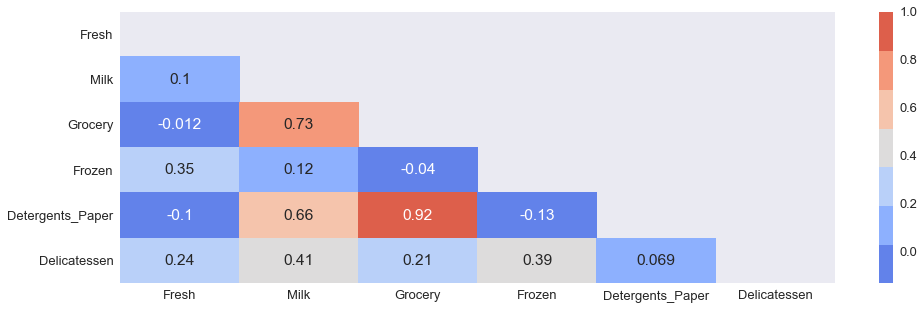

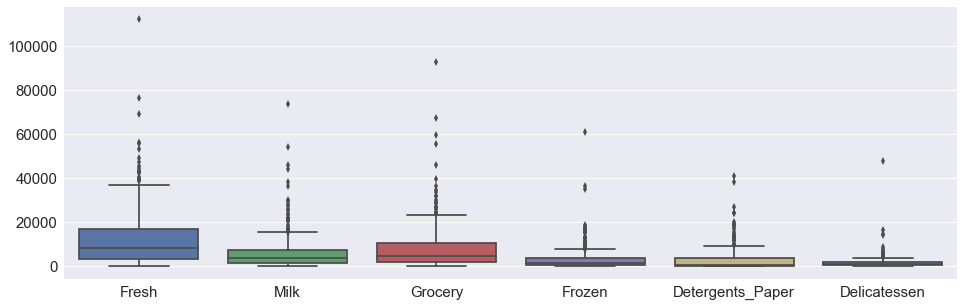

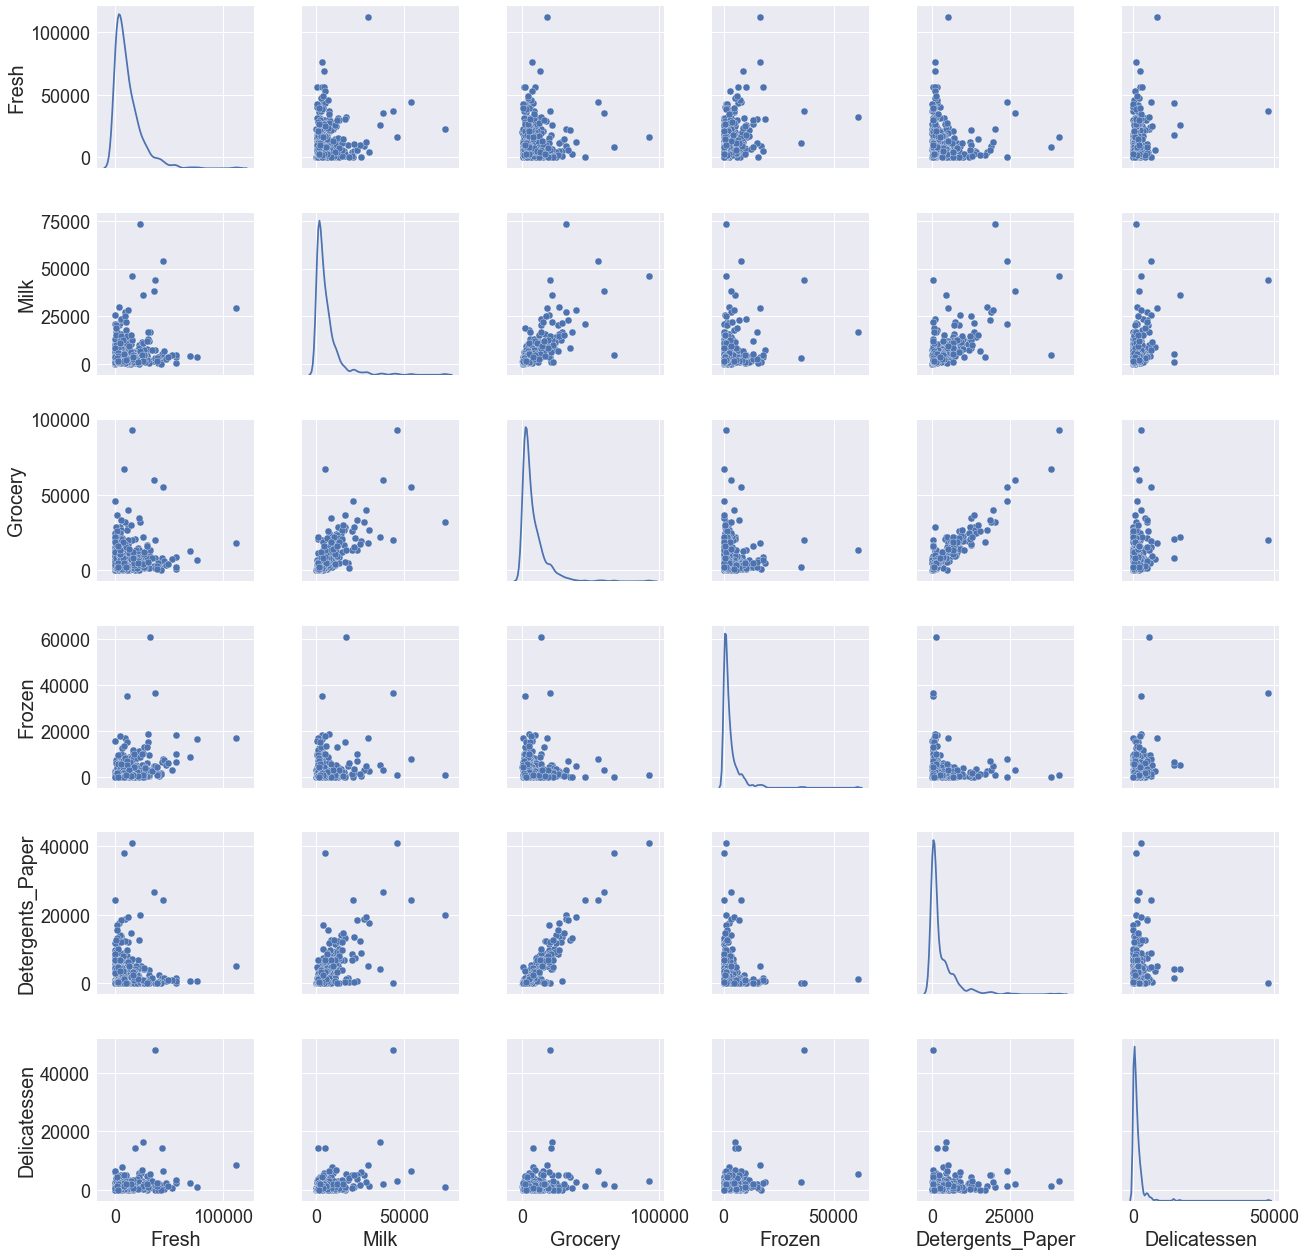

In [4]:
def plot_heatmap(df):
    plt.figure(figsize = (16,5))
    sns.set(font_scale=1.3)
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corr, mask=mask, cmap=sns.color_palette("coolwarm", 7), annot=True)

def plot_boxplot(df):
    plt.figure(figsize = (16,5))
    sns.set(font_scale=1.5)
    ax = sns.boxplot(data = df)

def plot_scatter_matrix(df):
    plt.figure(figsize = (12,5))
    sns.set(font_scale=1.8)
    sns.pairplot(df, diag_kind="kde", size=3)
    plt.show()
    #g = sns.PairGrid(df)
    #g.map_diag(sns.kdeplot)
    #g.map_offdiag(plt.scatter)
    #g.add_legend();

plot_heatmap(df)
plot_boxplot(df)
plot_scatter_matrix(df)

# Question 
**Answer:**
- The scatter matrix shows that these features are not normally distributed.
- These plots  are right skewed, with many values near zero and several outliers.
- Grocery and Detergents_paper show a strong correlation with coefficient 0.92.
- This confirms the answer about the relevance of Grocery and Detergents_paper.

## Selecting Sample Customers for Analysis

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
39,56159,555,902,10002,212,2916
56,4098,29892,26866,2616,17740,1340
71,18291,1266,21042,5373,4173,14472


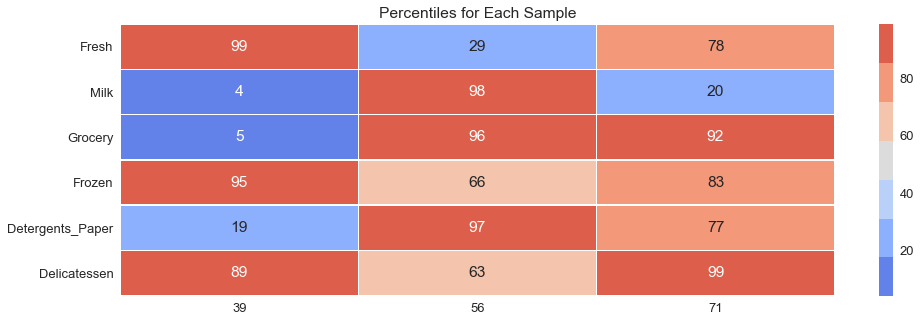

In [5]:
#indices = list(np.random.randint(len(df), size = 3))
#indices = [141,367,283]
indices = [39,56,71]

samples = pd.DataFrame(df.loc[indices])
display(samples)

plt.figure(figsize = (16,5))
sns.set(font_scale=1.3)
plt.title('Percentiles for Each Sample')
pct = (df.rank(pct=True).loc[indices]*100).astype(int)
sns.heatmap(pct.transpose(), linewidths=0.5, cmap=sns.color_palette("coolwarm", 7), annot=True)
plt.show()

# Question 
**Answer:**
- **Sample 1 (index = 141): Cafe**
 - Fresh        > mean
 - Milk         > mean
 - Grocery      > mean
 - Frozen       < mean
 - Det_Paper    < mean
 - Delicatessen > mean
 
 
- **Sample 2 (index = 367): Retailer**
 - Fresh        < mean
 - Milk         < mean
 - Grocery      < mean
 - Frozen       < mean
 - Det_Paper    < mean
 - Delicatessen < mean


- **Sample 3 (index = 283): Market**
 - Fresh        > mean
 - Milk         < mean
 - Grocery      < mean
 - Frozen       > mean
 - Det_Paper    < mean
 - Delicatessen > mean

## Feature Relevance
- **Are all features relevant?**
- **Can we predict any features from all of the others?**

In [6]:
scoring = 'r2'

results = {}
for feat in df.columns:
    y = df[feat]
    X = df.drop(feat, axis=1)   
    reg = DecisionTreeRegressor()
    score = np.mean(cross_val_score(reg, X, y, scoring=scoring, cv=5))
    results[feat] = score
    
display(pd.DataFrame({'r2_score': results}))

,r2_score
Delicatessen,-6.947057
Detergents_Paper,0.643169
Fresh,-0.842657
Frozen,-3.042708
Grocery,0.620125
Milk,0.214505


# Question 
**Answer:**
- Detergents_Paper has an R^2 score of 0.61
- Grocery has an R^2 score of 0.61
- This shows that information for these features is contained within the other features.
- These 2 features might not be necessary for the final model.

## Preprocessing
### Feature Scaling: Log Transform vs Box-Cox Transform for removing Skew

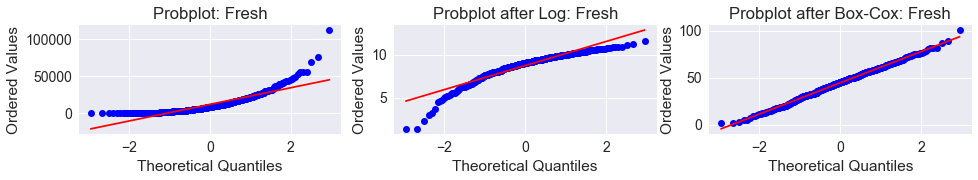

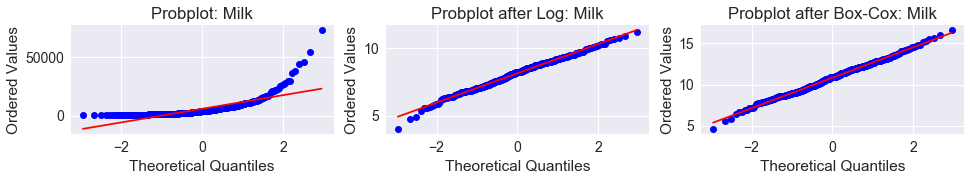

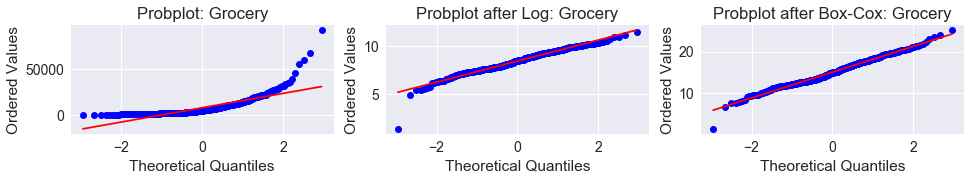

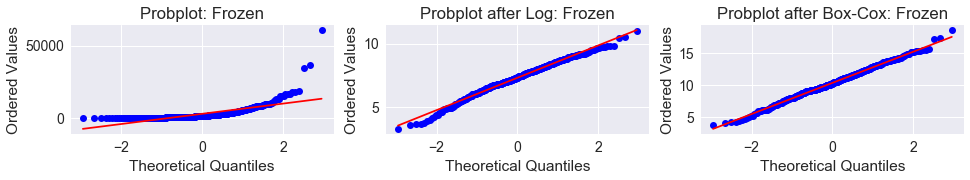

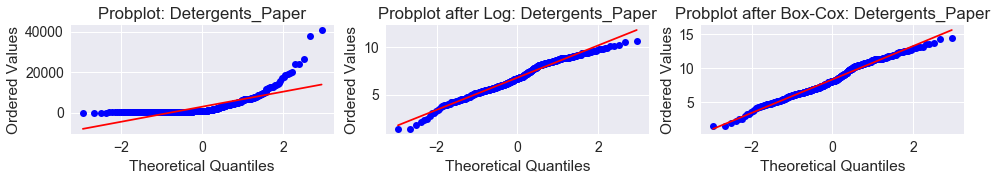

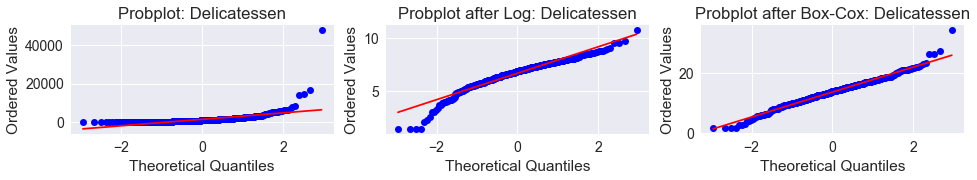

In [7]:
def plot_probplot(df, feat):
    x = df[feat]
    fig = plt.figure(figsize = (16,2))
    sns.set(font_scale=1.4)

    ax1 = fig.add_subplot(131)
    prob = probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('Theoretical Quantiles')
    ax1.set_title('Probplot: ' + feat)
    
    ax2 = fig.add_subplot(132)
    x2 = np.log(x + 1)
    prob = stats.probplot(x2, dist=stats.norm, plot=ax2)
    ax2.set_xlabel('Theoretical Quantiles')
    ax2.set_title('Probplot after Log: ' + feat)
    
    ax3 = fig.add_subplot(133)
    x3, _ = boxcox(x + 1)
    prob = stats.probplot(x3, dist=stats.norm, plot=ax3)
    ax3.set_xlabel('Theoretical Quantiles')
    ax3.set_title('Probplot after Box-Cox: ' + feat)
    
for feat in df.columns: plot_probplot(df, feat)

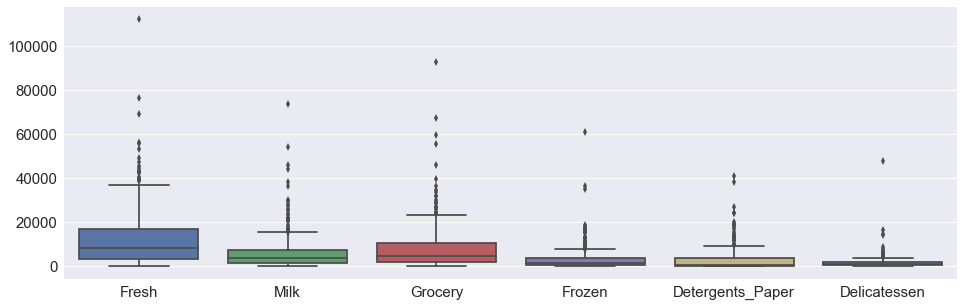

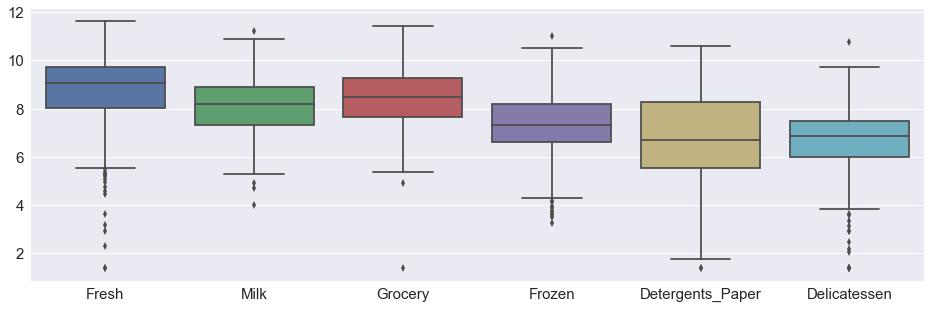

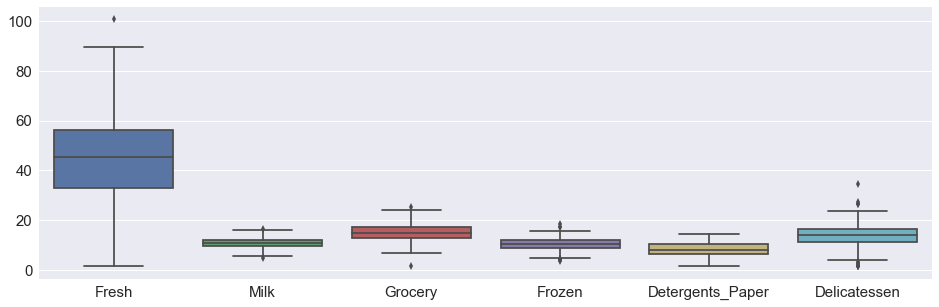

In [8]:
''' Box-Cox Transformation '''
boxcox_lambda = {}
boxcox_df = df.copy(deep=True)

for feat in df.columns: boxcox_df[feat], boxcox_lambda[feat] = boxcox(df[feat] + 1)
boxcox_samples = pd.DataFrame(boxcox_df.loc[indices])

''' Log Transformation '''
log_df = np.log(df+1)
log_samples = pd.DataFrame(log_df.loc[indices])

''' Visualization '''
#display(pd.DataFrame({'Box-Cox Lambda': boxcox_lambda}))
#display(samples)
#display(boxcox_samples)
#display(log_samples)

plot_boxplot(df)
plot_boxplot(log_df)
plot_boxplot(boxcox_df)

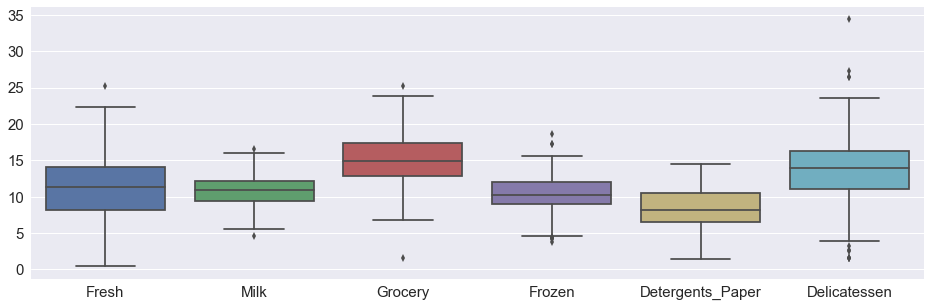

In [9]:
''' Scaling Fresh to match the other features '''
boxcox_df['Fresh'] = 0.25 * boxcox_df['Fresh']
plot_boxplot(boxcox_df)

In [10]:
''' Skew Comparison '''
df_skew, log_skew, boxcox_skew = {}, {}, {}

for feat in df.columns:
    df_skew[feat] = skew(df[feat])
    log_skew[feat] = skew(log_df[feat])
    boxcox_skew[feat] = skew(boxcox_df[feat])
    
results = pd.DataFrame({'df skew': df_skew, 'log skew': log_skew, 'boxcox skew': boxcox_skew})
display(results[['df skew','log skew','boxcox skew']])

,df skew,log skew,boxcox skew
Delicatessen,11.113534,-1.088101,0.095923
Detergents_Paper,3.619458,-0.235155,-0.016825
Fresh,2.552583,-1.569951,-0.041474
Frozen,5.887826,-0.351451,0.002632
Grocery,3.575187,-0.672635,0.031052
Milk,4.039922,-0.223299,0.001385


### Transform Selection

In [11]:
''' Transform Selection: BoxCox or Log '''
good_data = log_df.copy(deep=True)
#good_data = boxcox_df.copy(deep=True)

### Outlier Detection: Tukey's Method

In [12]:
''' Outlier Detection: Tukey's Method '''
outlier_dict = {}
for feature in good_data.keys():
    Q1 = np.percentile(good_data[feature], 25)
    Q3 = np.percentile(good_data[feature], 75)
    step = 1.5*(Q3-Q1)
    
    print("Data points considered outliers for the feature '{}':".format(feature))
    result = good_data[~((good_data[feature] >= Q1 - step) & (good_data[feature] <= Q3 + step))]
    display(result)
    
    for x in result.index:
        if x not in outlier_dict.keys(): outlier_dict[x] = 1
        else: outlier_dict[x] += 1
            
''' Outlier Detection (Removal): Tukey's Method '''
# How many categories is each sample an outlier?
outlier_1_cat, outlier_2_cat, outlier_3_cat = [], [], []

for x in outlier_dict.keys():
    if outlier_dict[x] == 1: outlier_1_cat.append(x)
    elif outlier_dict[x] == 2: outlier_2_cat.append(x)
    elif outlier_dict[x] == 3: outlier_3_cat.append(x)
        
#print ('\n1 Category:',outlier_1_cat)
print ('\n2 Category:',outlier_2_cat)
print ('\n3 Category:',outlier_3_cat)

#outliers = []
outliers  = [154,65, 66, 128, 75]
if outliers[0] in good_data.index:
    good_data = good_data.drop(good_data.index[outliers]) #.reset_index(drop = False)

print('\nDropping:', outliers)
print('\nDataframe Shape:',good_data.shape)

#display(good_data.loc[150:155])

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
81,5.393628,9.163354,9.575261,5.648974,8.964312,5.056246
95,1.386294,7.979681,8.740817,6.089045,5.411646,6.565265
96,3.178054,7.869784,9.001962,4.983607,8.262301,5.384495
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
171,5.303305,10.160569,9.894295,6.480045,9.079548,8.740497
193,5.198497,8.156510,9.918031,6.866933,8.633909,6.502790
218,2.944439,8.923325,9.629445,7.159292,8.475954,8.759826
304,5.087596,8.917445,10.117550,6.426488,9.374498,7.787797


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.040027,11.205027,10.377078,6.895683,9.907031,6.806829
98,6.222576,4.727388,6.658011,6.797940,4.043051,4.890349
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
356,10.029547,4.905275,5.389072,8.057694,2.302585,6.308098


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.432071,9.663325,9.723763,3.526361,8.847504,6.073045
57,8.597482,9.203718,9.257987,3.663562,8.932345,7.156956
65,4.454347,9.950371,10.732672,3.610918,10.095429,7.261225
145,10.000614,9.034200,10.457171,3.761200,9.440817,8.396381
175,7.759614,8.967759,9.382191,3.970292,8.342125,7.437206
264,6.979145,9.177817,9.645105,4.127134,8.696343,7.143618
325,10.395681,9.728241,9.519808,11.016496,7.149132,8.632306
420,8.402231,8.569216,9.490091,3.258097,8.827468,7.239933
429,9.060447,7.467942,8.183397,3.871201,4.442651,7.824846
439,7.933080,7.437795,7.828436,4.189655,6.169611,3.970292


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923241,7.037028,1.386294,8.391176,1.386294,6.883463
161,9.428270,6.293419,5.648974,6.996681,1.386294,7.711549


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.302585,7.336286,8.911665,5.170484,8.151622,3.332205
109,7.249215,9.724959,10.274603,6.513230,6.729824,1.386294
128,4.948760,9.087947,8.249052,4.962845,6.968850,1.386294
137,8.035279,8.997271,9.021961,6.495266,6.582025,3.610918
142,10.519673,8.875287,9.018453,8.005033,3.044522,1.386294
154,6.434547,4.025352,4.927254,4.330733,2.079442,2.197225
183,10.514557,10.690831,9.912001,10.506026,5.480639,10.777789
184,5.793014,6.823286,8.457655,4.317488,5.814131,2.484907
187,7.799343,8.987572,9.192176,8.743532,8.149024,1.386294
203,6.369901,6.530878,7.703910,6.152733,6.861711,2.944439



2 Category: [65, 66, 128, 75]

3 Category: [154]

Dropping: [154, 65, 66, 128, 75]

Dataframe Shape: (435, 6)


# Question 4
* Are there any data points considered outliers for more than one feature based on the definition above? 
* Should these data points be removed from the dataset? 
* If any data points were added to the `outliers` list to be removed, explain why.

** Hint: ** If you have datapoints that are outliers in multiple categories think about why that may be and if they warrant removal. Also note how k-means is affected by outliers and whether or not this plays a factor in your analysis of whether or not to remove them.

**Answer:**

## Feature Transformation: PCA

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,3.0500,-2.5713,0.1862,-0.0885,-1.4199,0.0047
1,-3.9273,-0.8383,0.2463,0.9821,0.3906,-0.2872
2,-1.4351,-2.7749,1.0828,-0.4339,-1.7057,1.5833


Text(0.5,1,'Cumulative Explained Variance vs. Number of PCs')

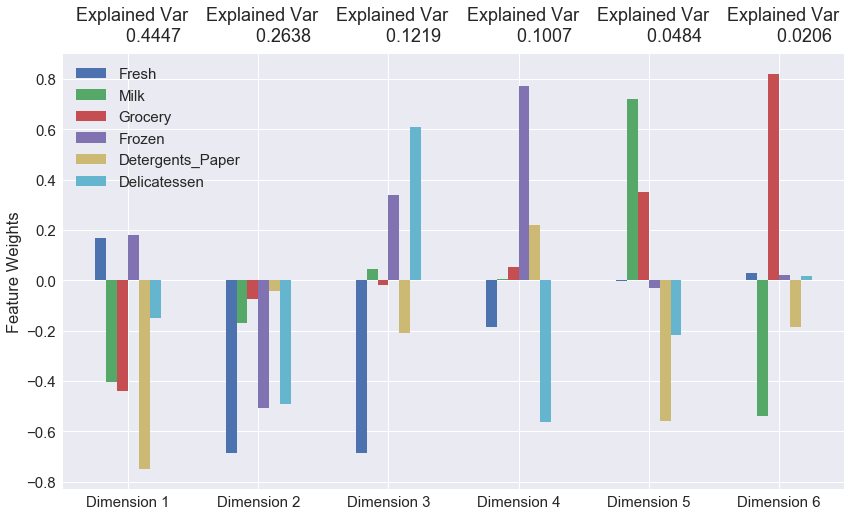

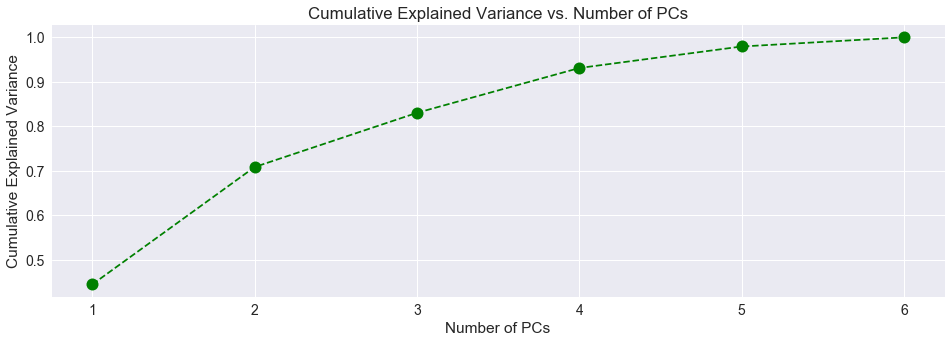

In [13]:
%run ./visuals.py
sns.set(font_scale=1.5)

n_components = 6

def pca_transform(n_components, good_data, log_samples):
    pca = PCA(n_components=n_components, random_state=0).fit(good_data)
    reduced_data = pca.transform(good_data)
    pca_samples = pca.transform(log_samples)
    pca_res = pca_results(good_data, pca)
    return reduced_data, pca_samples, pca_res, pca
    
reduced_data, pca_samples, pca_res, pca = pca_transform(n_components, good_data, log_samples)
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_res.index.values))

n_components = np.arange(1, 7)
cumulative_var_exp = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (16,5))
sns.set(font_scale=1.4)
plt.plot(n_components, cumulative_var_exp, 'go--', markersize=12)
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of PCs')

# Question 5

* How much variance in the data is explained* **in total** *by the first and second principal component? 
* How much variance in the data is explained by the first four principal components? 
* Using the visualization provided above, talk about each dimension and the cumulative variance explained by each, stressing upon which features are well represented by each dimension(both in terms of positive and negative variance explained). Discuss what the first four dimensions best represent in terms of customer spending.

**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the individual feature weights.

**Answer:**

## Dimensionality Reduction: PCA

,Dimension 1,Dimension 2
0,3.0500,-2.5713
1,-3.9273,-0.8383
2,-1.4351,-2.7749


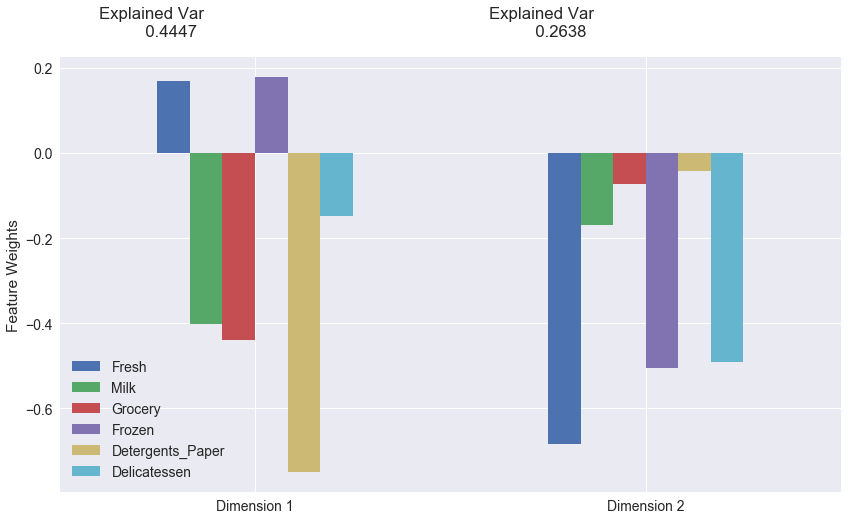

In [14]:
n_components = 2
    
reduced_data, pca_samples, pca_res, pca = pca_transform(n_components, good_data, log_samples)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
          
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

## Visualizing a Biplot

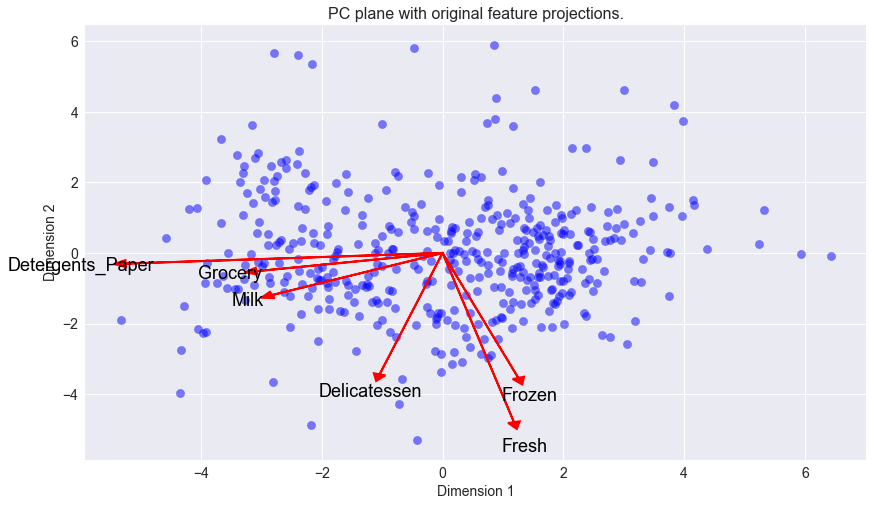

In [15]:
biplot(good_data, reduced_data, pca)

### Observation

Once we have the original feature projections (in red), it is easier to interpret the relative position of each data point in the scatterplot. For instance, a point the lower right corner of the figure will likely correspond to a customer that spends a lot on `'Milk'`, `'Grocery'` and `'Detergents_Paper'`, but not so much on the other product categories. 

From the biplot, which of the original features are most strongly correlated with the first component? What about those that are associated with the second component? Do these observations agree with the pca_results plot you obtained earlier?

## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

# Question 6

* What are the advantages to using a K-Means clustering algorithm? 
* What are the advantages to using a Gaussian Mixture Model clustering algorithm? 
* Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?

** Hint: ** Think about the differences between hard clustering and soft clustering and which would be appropriate for our dataset.

**Answer:**

### Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In [16]:
def gaussian_mixture_model(n_clusters):
    
    clu = GaussianMixture(n_components = n_clusters, random_state = 0).fit(reduced_data)
    preds = clu.predict(reduced_data)
    centers = clu.means_

    sample_preds = clu.predict(pca_samples)
    score = silhouette_score(reduced_data, preds)
    
    print ('The silhouette score for {} clusters is: {:.4f}'.format(n_clusters, score))
    return clu, preds, centers, sample_preds, score

for n_clusters in range(2,7): 
    clu, preds, centers, sample_preds, score = gaussian_mixture_model(n_clusters)

The silhouette score for 2 clusters is: 0.4229
The silhouette score for 3 clusters is: 0.3705
The silhouette score for 4 clusters is: 0.3303
The silhouette score for 5 clusters is: 0.3096
The silhouette score for 6 clusters is: 0.3301


# Question 7

* Report the silhouette score for several cluster numbers you tried. 
* Of these, which number of clusters has the best silhouette score?

**Answer:**

### Cluster Visualization

The silhouette score for 2 clusters is: 0.4229


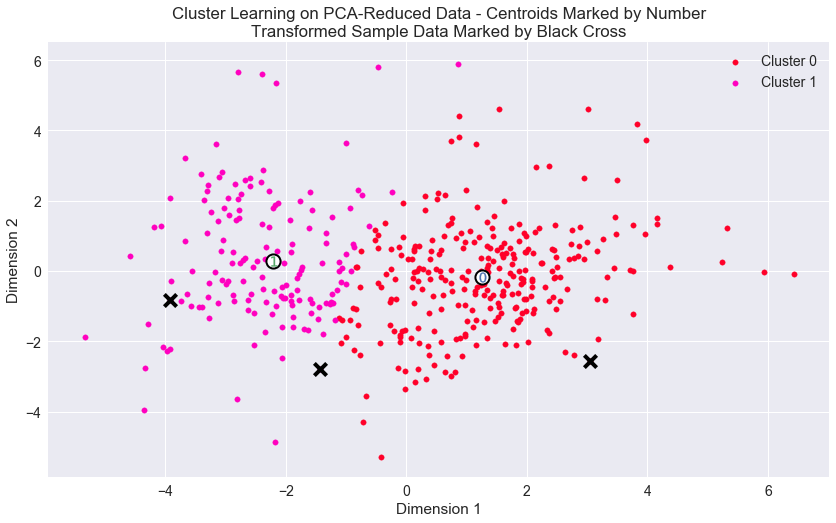

In [17]:
n_clusters = 2

clu, preds, centers, sample_preds, score = gaussian_mixture_model(n_clusters)
cluster_results(reduced_data, preds, centers, pca_samples)

## Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [18]:
log_centers = pca.inverse_transform(centers)
true_centers = np.exp(log_centers)
#true_centers = inv_boxcox(log_centers, boxcox_lambda)

segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = df.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8937.0,2100.0,2747.0,2076.0,353.0,731.0
Segment 1,3604.0,7878.0,12261.0,878.0,4695.0,976.0


# Question 8

* Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project(specifically looking at the mean values for the various feature points). What set of establishments could each of the customer segments represent?

**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`. Think about what each segment represents in terms their values for the feature points chosen. Reference these values with the mean values to get some perspective into what kind of establishment they represent.

**Answer:**

# Question 9

* For each sample point, which customer segment from* **Question 8** *best represents it? 
* Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [19]:
for i, pred in enumerate(sample_preds):
    print("Sample point", i, "predicted to be in Cluster", pred)

Sample point 0 predicted to be in Cluster 0
Sample point 1 predicted to be in Cluster 1
Sample point 2 predicted to be in Cluster 1


**Answer:**

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. 

* How can the wholesale distributor use the customer segments to determine which customers, if any, would react positively to the change in delivery service?*

**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
* How can the wholesale distributor label the new customers using only their estimated product spending and the **customer segment** data?

**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

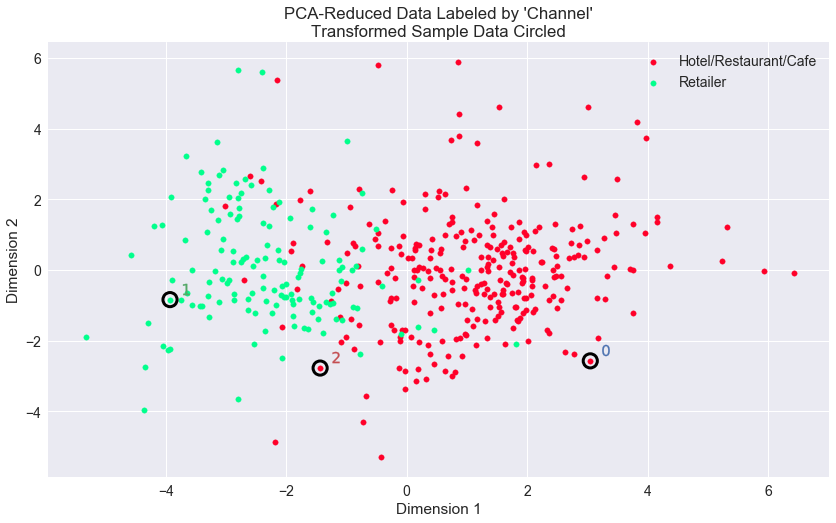

In [20]:
channel_results(reduced_data, outliers, pca_samples)

### Question 12

* How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? 
* Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? 
* Would you consider these classifications as consistent with your previous definition of the customer segments?

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.